In [1]:
import arviz as az
import pandas as pd
import numpy as np
import sqlite3
import os
import pprint
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from helper import *
import bambi as bmb
import pymc as pm
from multiprocessing import cpu_count

pp = pprint.PrettyPrinter(indent=2)

%matplotlib inline

# Data Collection

In [2]:
current_folder = os.path.abspath('')
db_file = os.path.join(current_folder, r"data/data.db")
db = sqlite3.connect(db_file)

In [3]:
query = r""" 
    SELECT events, launch_angle, launch_speed, estimated_ba_using_speedangle, hc_x, hc_y, hit_distance_sc, stand, bb_type
    FROM statcast
    WHERE type = 'X' AND
        events NOT LIKE 'sac_%'
"""
raw_data = pd.read_sql_query(query, db)

In [4]:
data = raw_data.copy()
hit_events = {
    'single':1,
    'double':2,
    'triple':3,
    'home_run':4
}

data = data.dropna(axis='index')
data['is_hit'] = np.where(data['events'].isin(hit_events.keys()), 1, 0)
data['bases_earned'] = data.apply(get_bases_earned, axis='columns')
data['spray_angle'] = data.apply(get_spray_angle, axis='columns')

In [5]:
rng = np.random.RandomState(seed=6420)
X_train, X_test, y_train, y_test = train_test_split(data.drop("is_hit", axis="columns"), data["is_hit"], test_size = 0.3, random_state=rng)

# Baseline

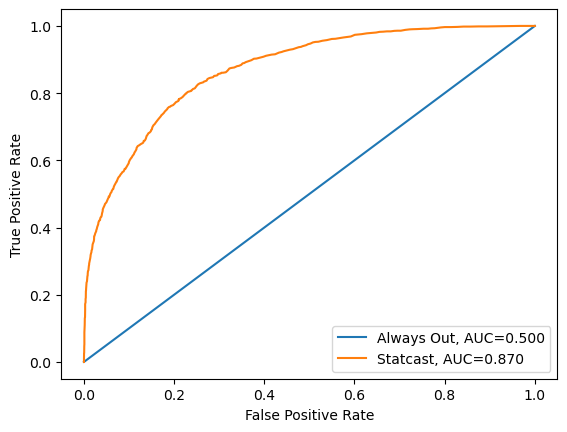

In [6]:
always_out = np.zeros_like(y_test)
plt.figure(0).clf()

fpr_ao, tpr_ao, _ = roc_curve(y_test, always_out)
auc_ao = roc_auc_score(y_test, always_out)
fpr_statcast, tpr_statcast, _ = roc_curve(y_test, X_test['estimated_ba_using_speedangle'])
auc_statcast = roc_auc_score(y_test, X_test['estimated_ba_using_speedangle'])

plt.plot(fpr_ao, tpr_ao, label=f"Always Out, AUC={auc_ao:0.3f}")
plt.plot(fpr_statcast, tpr_statcast, label=f"Statcast, AUC={auc_statcast:0.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

            Accuracy  Sensitivity  Specificity  F1 Score
Always Out  0.670866     0.000000     1.000000  0.000000
Statcast    0.800388     0.606968     0.895282  0.666846


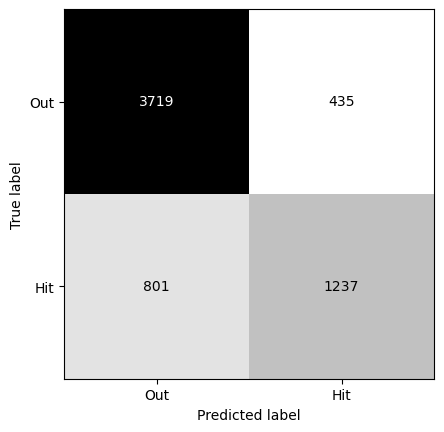

In [7]:
cm_ao = confusion_matrix(y_test, always_out)
cm_statcast = confusion_matrix(y_test, np.round(X_test['estimated_ba_using_speedangle']))

eda_scores = pd.DataFrame([cm_scores(y_test, always_out), 
                           cm_scores(y_test, np.round(X_test['estimated_ba_using_speedangle']))],
                           index=["Always Out", "Statcast"])
print(eda_scores)

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=np.round(X_test['estimated_ba_using_speedangle']),
                                        display_labels=["Out", "Hit"], colorbar=False, cmap="binary");

# Standard Logisitic Regression

{ 'Accuracy': 0.7525839793281653,
  'F1 Score': 0.5976890756302521,
  'Sensitivity': 0.5583905789990187,
  'Specificity': 0.8478574867597496}


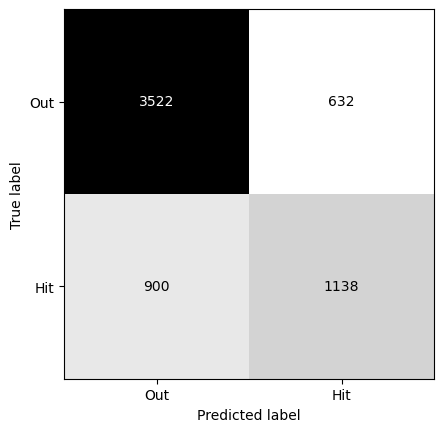

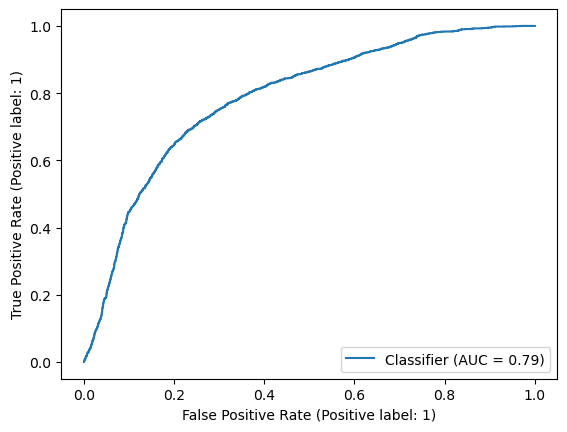

In [8]:
speed_angle_train = X_train[["launch_speed", "launch_angle", "hit_distance_sc"]].copy()
speed_angle_train["interaction"] = speed_angle_train.loc[:,"launch_angle"] * speed_angle_train.loc[:,"hit_distance_sc"]
speed_angle_test = X_test[["launch_speed", "launch_angle", "hit_distance_sc"]].copy()
speed_angle_test["interaction"] = speed_angle_test.loc[:,"launch_angle"] * speed_angle_test.loc[:,"hit_distance_sc"]
logit_model = LogisticRegression().fit(speed_angle_train, y_train)
logit_pred = logit_model.predict_proba(speed_angle_test)
logit_pred = [p[1] for p in logit_pred]

ConfusionMatrixDisplay.from_predictions(y_test, np.round(logit_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, logit_pred);
pp.pprint(cm_scores(y_test, np.round(logit_pred)))

# Bayesian Model

In [9]:
bayes_data = pd.concat([y_train, X_train], axis="columns")

## Exit Velo - Launch Angle Only Model

In [10]:
priors = {
    "launch_speed": bmb.Prior("Normal", mu=0, sigma=10),
    "launch_angle": bmb.Prior("Normal", mu=0, sigma=10)
}
bayes_model = bmb.Model("is_hit ~ launch_angle + launch_speed", data=bayes_data, priors=priors, family="bernoulli")
model_filepath = os.path.join(current_folder, r"models/bayes_basic.model")
if os.path.exists(model_filepath):
    bayes_results = az.from_netcdf(model_filepath)
else:
    bayes_results = bayes_model.fit(chains=4, cores=cpu_count(), inference_method="nuts_numpyro")
    az.to_netcdf(bayes_results, model_filepath)

In [11]:
bayes_model.predict(bayes_results, data=X_test, kind="pps")

{ 'Accuracy': 0.6844315245478036,
  'F1 Score': 0.17552742616033754,
  'Sensitivity': 0.10206084396467124,
  'Specificity': 0.9701492537313433}


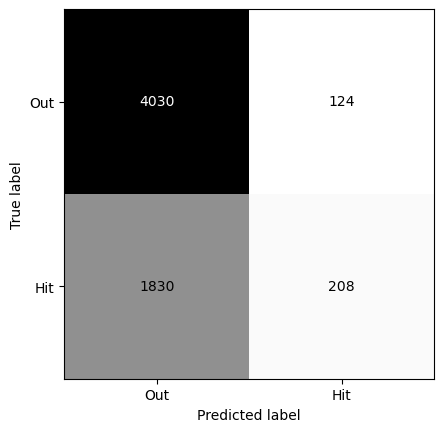

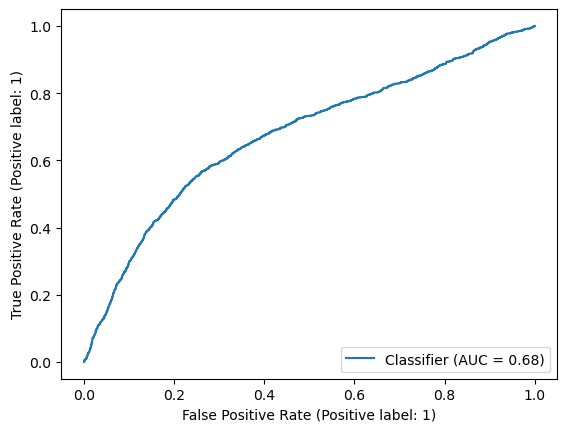

In [12]:
bayes_pred = bayes_results.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred);
pp.pprint(cm_scores(y_test, np.round(bayes_pred)))


## Extended Model

In [25]:
full_model_spec = {
    "file_name":"bayes_full_type.model",
    "formula":"is_hit ~ (launch_speed + hit_distance_sc + spray_angle | bb_type)",
    "priors": {
        "(1|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(launch_speed|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(hit_distance_sc|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(spray_angle|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
    }
}
spray_angle_model_spec = {
    "file_name":"bayes_spray_angle_type.model",
    "formula":"is_hit ~ (launch_speed + spray_angle | bb_type)",
    "priors": {
        "(1|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(launch_speed|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(spray_angle|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
    }
}
hit_distance_model_spec = {
    "file_name":"bayes_distance_type.model",
    "formula":"is_hit ~ (launch_speed + hit_distance_sc | bb_type)",
    "priors": {
        "(1|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(launch_speed|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
        "(hit_distance_sc|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
    }
}

In [41]:
def load_or_build_model(model_spec: dict):
    model_filepath = os.path.join(os.path.abspath(''), "models", model_spec["file_name"])
    model = bmb.Model(model_spec["formula"], data=bayes_data, priors=model_spec["priors"], family="bernoulli")
    if os.path.exists(model_filepath):
        results = az.from_netcdf(model_filepath)
    else:
        results = model.fit(tune=500, draws=1000,chains=4, 
            cores=cpu_count(), inference_method="nuts_numpyro")
        az.to_netcdf(results, model_filepath)
    return (model, results)

def model_accuracy_viz(model, results, test_data, model_name = None, disp = True):
    model.predict(results, data=test_data, kind="pps")
    predictions = results.posterior["is_hit_mean"].values.mean(0).mean(0)
    cm = confusion_matrix(y_test, np.round(predictions))
    fpr, tpr, _ = roc_curve(y_test, np.round(predictions))
    auc = roc_auc_score(y_test, np.round(predictions))
    acc_scores = cm_scores(y_test, np.round(predictions))
    if disp:
        if model_name:
            pp.pprint(model_name)
        pp.pprint(acc_scores)
        ConfusionMatrixDisplay.from_predictions(y_test, np.round(predictions), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
        RocCurveDisplay.from_predictions(y_test, predictions);
    return {
        "cm": cm,
        "roc": (fpr, tpr, auc)
        "scores": acc_scores
    }

In [27]:
full_model, full_results = load_or_build_model(full_model_spec)
sa_model, sa_results = load_or_build_model(spray_angle_model_spec)
dist_model, dist_results = load_or_build_model(hit_distance_model_spec)

'Full Model'
{ 'Accuracy': 0.7787467700258398,
  'F1 Score': 0.6447095435684648,
  'Sensitivity': 0.6099116781157998,
  'Specificity': 0.8615792007703419}


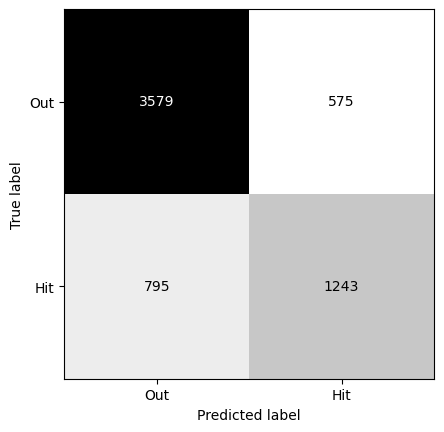

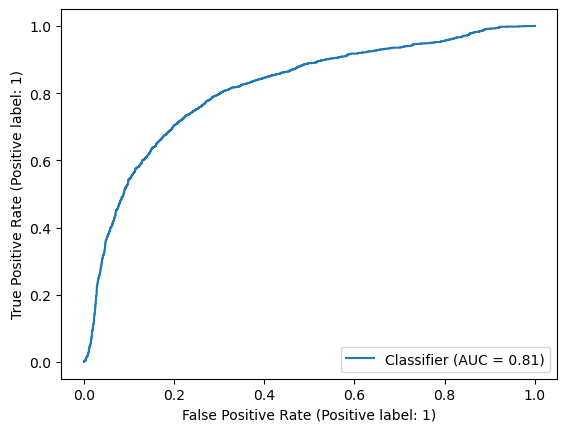

In [42]:
model_accuracy_viz(full_model, full_results, X_test, model_name = "Full Model")

In [20]:
selected_model = full_model_spec
model_filepath = os.path.join(current_folder, "models", selected_model["file_name"])

bayes_model2 = bmb.Model(selected_model["formula"], data=bayes_data, priors=selected_model["priors"], family="bernoulli")
if os.path.exists(model_filepath):
    bayes_results2 = az.from_netcdf(model_filepath)
else:
    bayes_results2 = bayes_model2.fit(tune=500, draws=1000,chains=4, 
        cores=cpu_count(), inference_method="nuts_numpyro")
    az.to_netcdf(bayes_results2, model_filepath)

Modeling the probability that is_hit==1
/home/mattb/mambaforge/envs/bayes/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:04.087258
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
bayes_model2.predict(bayes_results2, data=X_test, kind="pps")

'bayes_full_type_effects_all_intercepts.model'
{ 'Accuracy': 0.7787467700258398,
  'F1 Score': 0.6447095435684648,
  'Sensitivity': 0.6099116781157998,
  'Specificity': 0.8615792007703419}


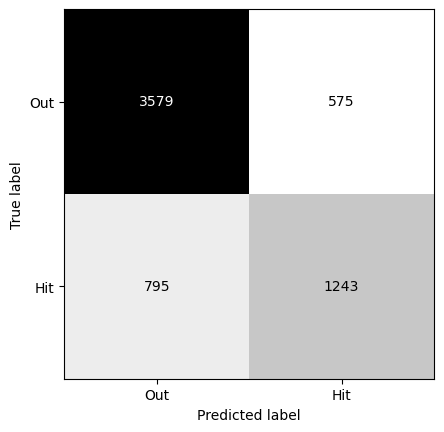

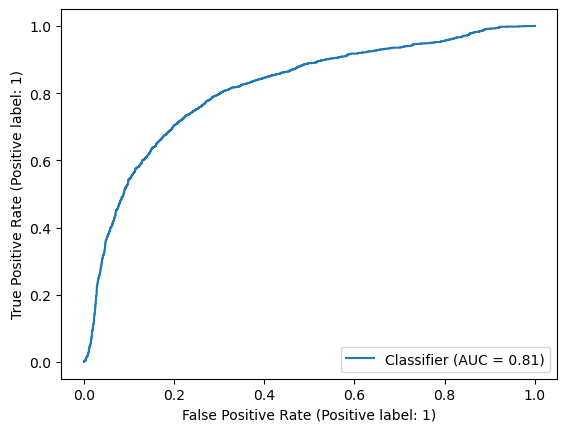

In [23]:
bayes_pred2 = bayes_results2.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred2), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred2);
pp.pprint(selected_model["file_name"])
pp.pprint(cm_scores(y_test, np.round(bayes_pred2)))


'bayes_full_type_effects_single_intercept.model'
{ 'Accuracy': 0.7747093023255814,
  'F1 Score': 0.6306592533756951,
  'Sensitivity': 0.584396467124632,
  'Specificity': 0.8680789600385171}


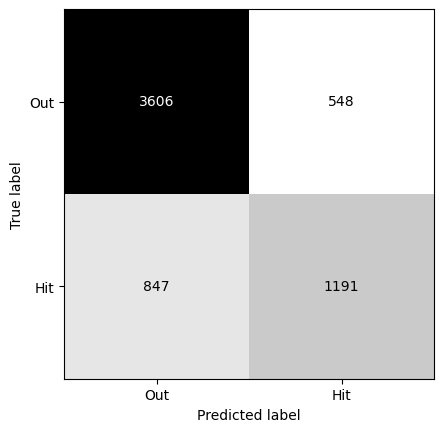

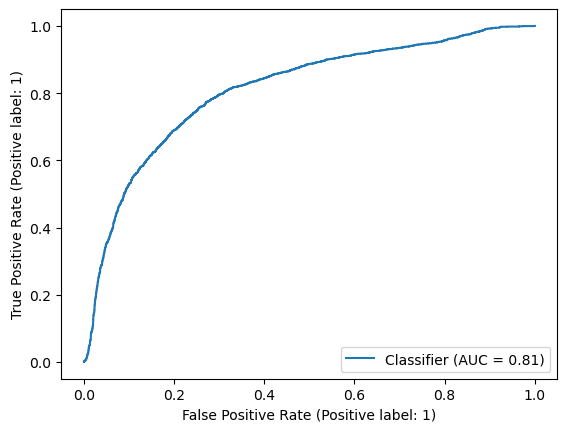

In [17]:
bayes_pred2 = bayes_results2.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred2), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred2);
pp.pprint(selected_model["file_name"])
pp.pprint(cm_scores(y_test, np.round(bayes_pred2)))


'bayes_full_type_effects_type_intercepts.model'
{ 'Accuracy': 0.7781007751937985,
  'F1 Score': 0.6436721991701244,
  'Sensitivity': 0.6089303238469087,
  'Specificity': 0.8610977371208474}


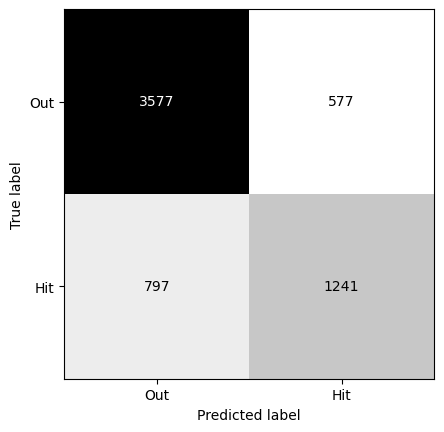

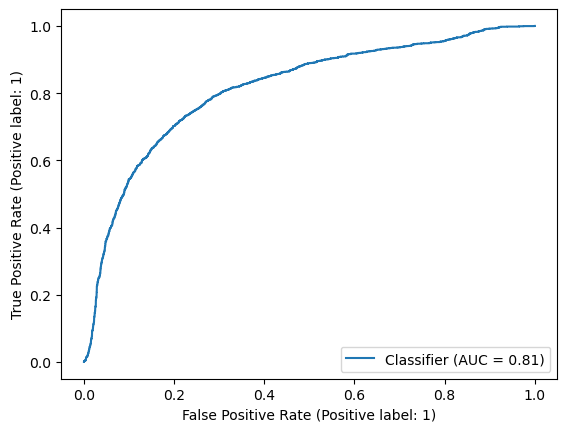

In [17]:
bayes_pred2 = bayes_results2.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred2), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred2);
pp.pprint(selected_model["file_name"])
pp.pprint(cm_scores(y_test, np.round(bayes_pred2)))

'bayes_spray_angle_type.model'
{ 'Accuracy': 0.7532299741602068,
  'F1 Score': 0.5936170212765957,
  'Sensitivity': 0.5475956820412169,
  'Specificity': 0.8541165142031777}


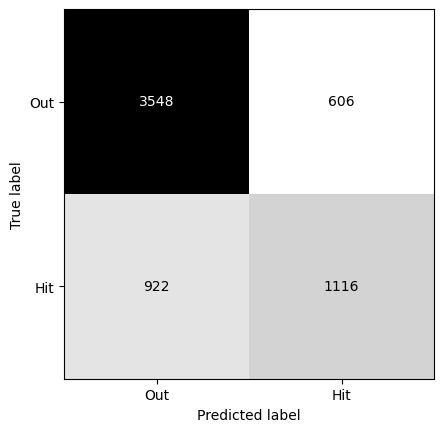

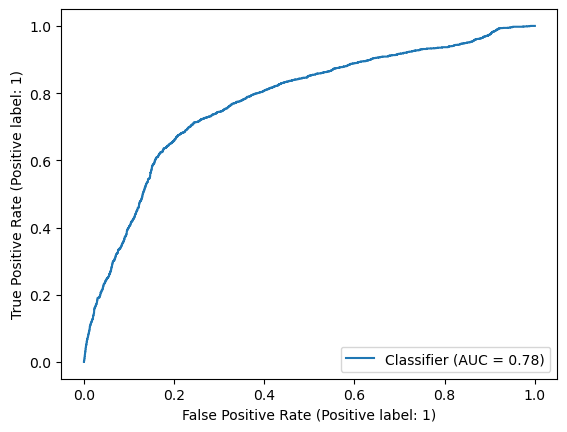

In [20]:
bayes_pred2 = bayes_results2.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred2), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred2);
pp.pprint(selected_model["file_name"])
pp.pprint(cm_scores(y_test, np.round(bayes_pred2)))

'bayes_distance_type.model'
{ 'Accuracy': 0.773578811369509,
  'F1 Score': 0.630858346498157,
  'Sensitivity': 0.5878312070657508,
  'Specificity': 0.8647087144920559}


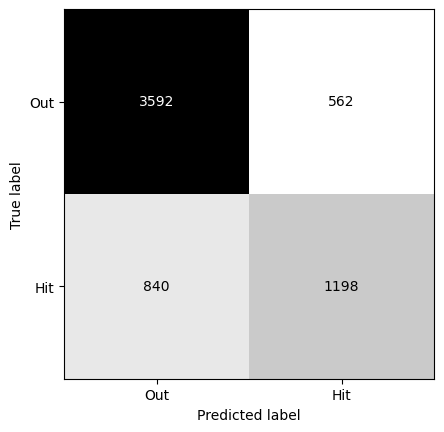

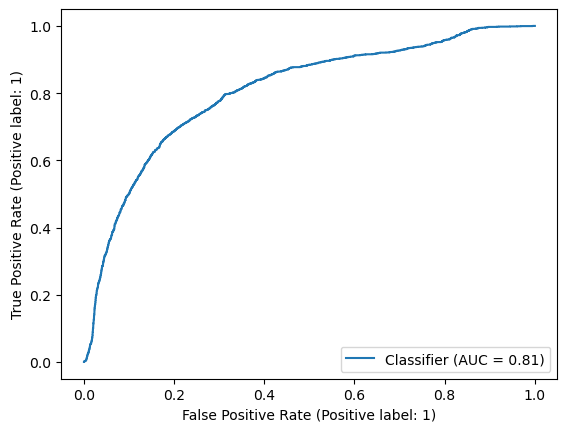

In [26]:
bayes_pred2 = bayes_results2.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred2), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred2);
pp.pprint(selected_model["file_name"])
pp.pprint(cm_scores(y_test, np.round(bayes_pred2)))